In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf

from patsy import dmatrices, dmatrix, build_design_matrices

import math

In [22]:
#for checking accuracy
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

In [23]:
elect_df = pd.read_csv("Obama.csv")

In [24]:
#Feature Engineering
elect_df['youth_population_ratio'] = elect_df['AgeBelow35'] / elect_df['Pop']
elect_df['gender_balance_index'] = elect_df['MalesPer100Females'] / 100
elect_df['income_disparity_index'] = elect_df['MedianIncome'] / elect_df['AverageIncome']
elect_df['poverty_rate'] = elect_df['Poverty'] / elect_df['Pop']
elect_df['social_security_dependency'] = elect_df['SocialSecurity'] / elect_df['Pop']
elect_df['senior_population_ratio'] = elect_df['Age65andAbove'] / elect_df['Pop']
elect_df['lower_education_ratio'] = (elect_df['HighSchool'] - elect_df['Bachelors']) / elect_df['Pop']
elect_df['homeownership_rate'] = elect_df['Homeowner'] / elect_df['Pop']
elect_df['long_term_residency_rate'] = elect_df['SameHouse1995and2000'] / elect_df['Homeowner']
elect_df['income_level_indicator'] = elect_df['AverageIncome'] / elect_df['MedianIncome']
elect_df['adjusted_unemployment_rate'] = elect_df['UnemployRate'] / elect_df['Pop']
elect_df['age_income_interaction'] = (elect_df['Age65andAbove'] * elect_df['MedianIncome']) / elect_df['Pop']
elect_df['healthcare_dependency_ratio'] = elect_df['MedicareRate'] / elect_df['Pop']
elect_df['disability_rate_indicator'] = elect_df['Disabilities'] / elect_df['Pop']

In [25]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [26]:
#for separating trainning and testing
elect_df["ElectionDate"] = pd.to_datetime(elect_df["ElectionDate"])
elect_df_train = elect_df[elect_df["ElectionDate"] < pd.to_datetime("2/19/2008")].copy()
elect_df_test = elect_df[elect_df["ElectionDate"] >= pd.to_datetime("2/19/2008")].copy()
elect_df_train["Obama_margin"] = elect_df_train["Obama"] - elect_df_train["Clinton"]
elect_df_train["Obama_margin_percent"] = elect_df_train["Obama_margin"] / elect_df_train["TotalVote"]
elect_df_train["Obama_wins"] = elect_df_train["Obama_margin"] > 0

In [27]:
#for creating database + imputer
final_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
final_imputer.fit(elect_df_train.loc[:, "MalesPer100Females":"disability_rate_indicator"])
elect_df_train.loc[:, "MalesPer100Females":"disability_rate_indicator"] = final_imputer.transform(elect_df_train.loc[:, "MalesPer100Females":"disability_rate_indicator"])
elect_df_test.loc[:, "MalesPer100Females":"disability_rate_indicator"] = final_imputer.transform(elect_df_test.loc[:, "MalesPer100Females":"disability_rate_indicator"])

In [28]:
#Split trainning set into smaller + imputer
elect_df_smaller_train, elect_df_validation = train_test_split(elect_df_train, test_size=.25, random_state=201)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(elect_df_smaller_train.loc[:, "MalesPer100Females":"disability_rate_indicator"])
elect_df_smaller_train.loc[:, "MalesPer100Females":"disability_rate_indicator"] = imputer.transform(elect_df_smaller_train.loc[:, "MalesPer100Females":"disability_rate_indicator"])
elect_df_validation.loc[:, "MalesPer100Females":"disability_rate_indicator"] = imputer.transform(elect_df_validation.loc[:, "MalesPer100Females":"disability_rate_indicator"])

In [29]:
#Lasso
variables = [variable for variable in elect_df_smaller_train.columns if variable not in ['FIPS', 'County', 'State', 'ElectionDate', 'TotalVote', 'Obama_margin', 'Obama_margin_percent', 'Obama_wins', 'Clinton', 'Obama']]
formula = 'Obama_margin_percent ~ ' + "+ ".join(variables[:2]) +  " + standardize(" + ") + standardize(".join(variables[2:]) + ")"
print(formula)
y_linear, X_linear = dmatrices(formula, elect_df_smaller_train, return_type="dataframe")
lm_lasso = Lasso(alpha = 1, max_iter=1000000)
lm_lasso.fit(X_linear, y_linear)
X_validation_linear = build_design_matrices([X_linear.design_info], elect_df_validation, return_type="dataframe")[0]
lm_lass_pred = lm_lasso.predict(X_validation_linear)

Obama_margin_percent ~ Region+ ElectionType + standardize(MalesPer100Females) + standardize(AgeBelow35) + standardize(Age35to65) + standardize(Age65andAbove) + standardize(White) + standardize(Black) + standardize(Asian) + standardize(AmericanIndian) + standardize(Hawaiian) + standardize(Hispanic) + standardize(HighSchool) + standardize(Bachelors) + standardize(Poverty) + standardize(IncomeAbove75K) + standardize(MedianIncome) + standardize(AverageIncome) + standardize(UnemployRate) + standardize(ManfEmploy) + standardize(SpeakingNonEnglish) + standardize(Medicare) + standardize(MedicareRate) + standardize(SocialSecurity) + standardize(SocialSecurityRate) + standardize(RetiredWorkers) + standardize(Disabilities) + standardize(DisabilitiesRate) + standardize(Homeowner) + standardize(SameHouse1995and2000) + standardize(Pop) + standardize(PopDensity) + standardize(LandArea) + standardize(FarmArea) + standardize(youth_population_ratio) + standardize(gender_balance_index) + standardize(inco

In [30]:
accuracy(lm_lass_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.311966,0.254121,-8085241931389026900314719128649728.000000


In [31]:
#finding the best alphas
alphas = np.logspace(-5,0, 20)


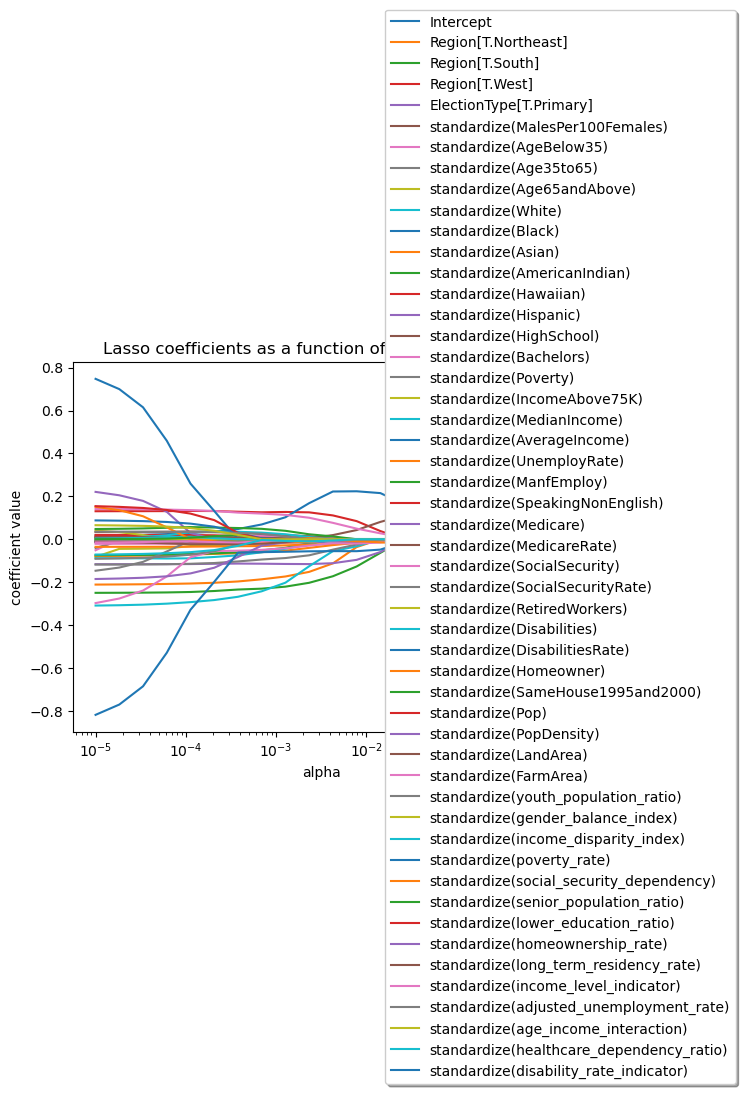

CPU times: user 3.65 s, sys: 29.8 ms, total: 3.68 s
Wall time: 3.68 s


In [32]:
%%time
coefs = []
for a in alphas:
    lm_lasso = Lasso(alpha=a, max_iter=1000000)
    lm_lasso.fit(X_linear, y_linear)
    coefs.append(lm_lasso.coef_)
    ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.show()

In [33]:
gs_lasso = GridSearchCV(Lasso(max_iter=1000000), {"alpha": alphas}, scoring='neg_mean_squared_error', cv=4)

In [34]:
%%time
gs_lasso.fit(X_linear, y_linear)
gs_lasso.best_params_['alpha']

CPU times: user 11.2 s, sys: 6.62 ms, total: 11.2 s
Wall time: 11.2 s


0.0012742749857031334

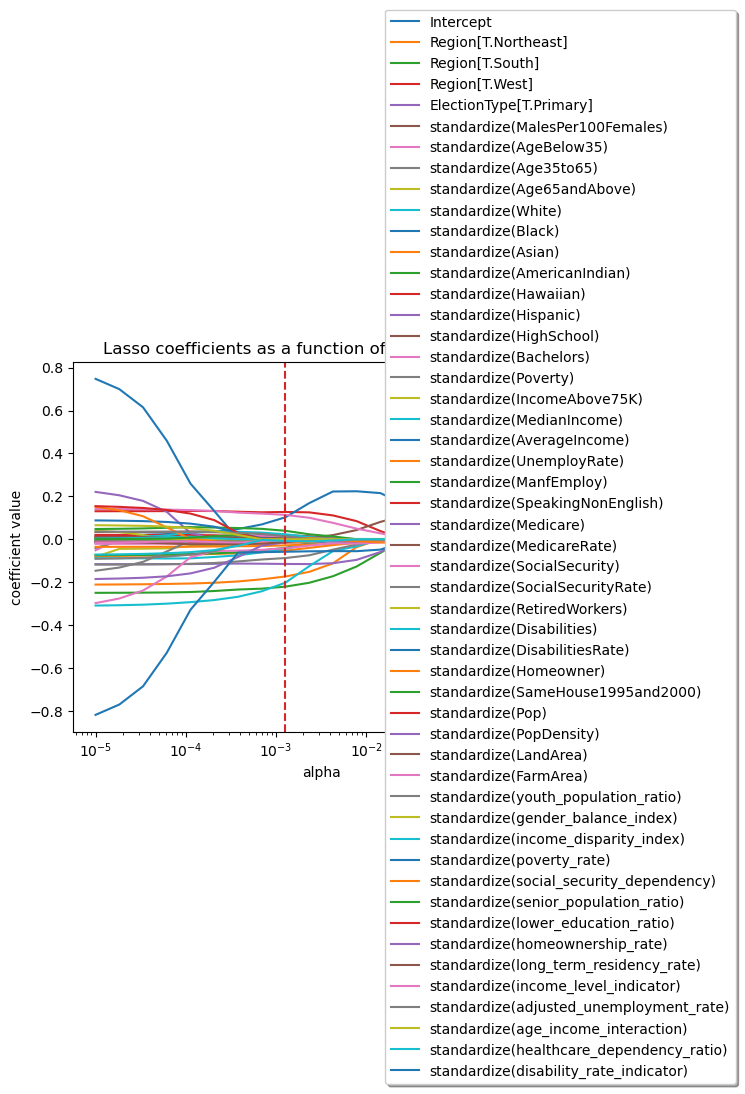

In [35]:
ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.axvline(x=gs_lasso.best_params_['alpha'], linestyle='--', color='tab:red')
plt.show()

In [36]:
lm_lasso_optimized = Lasso(alpha = gs_lasso.best_params_['alpha'], max_iter=1000000)
lm_lasso_optimized.fit(X_linear,y_linear)

Lasso(alpha=0.0012742749857031334, max_iter=1000000)

In [37]:
lm_lasso_optimized_pred = lm_lasso_optimized.predict(X_validation_linear)

In [38]:
gs_lasso_pred = gs_lasso.predict(X_validation_linear)

In [39]:
print("Accuracy of the lm_lasso_optimized model:")
accuracy(lm_lasso_optimized_pred, elect_df_validation["Obama_margin_percent"])
print("Accuracy of the gs_lasso model:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])

Accuracy of the lm_lasso_optimized model:


RMSE,MAE,R^2
0.168230,0.127251,0.567657


Accuracy of the gs_lasso model:


RMSE,MAE,R^2
0.168230,0.127251,0.567657


In [40]:
def get_linear_importances(model, data):
    # This section is to handle both LASSO and ridge.
    if len(model.coef_) == 1:
        coefficients = np.concatenate((model.coef_[0], [model.intercept_]))
    else:
        coefficients = np.concatenate((model.coef_, model.intercept_))
    coef_df = pd.DataFrame({'Importance': coefficients}, index=data.columns.append(pd.Index(["Model Intercept"])))
    return coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

In [41]:
get_linear_importances(lm_lasso_optimized, X_linear)

,Importance
Region[T.South],-0.221095
standardize(White),-0.202554
Region[T.Northeast],-0.173691
Model Intercept,0.162974
Region[T.West],0.127196
ElectionType[T.Primary],-0.115310
standardize(Bachelors),0.113555
standardize(Black),0.102425
standardize(Poverty),-0.087725
standardize(disability_rate_indicator),-0.058386


In [42]:
print("gs_lasso accuracy:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])

gs_lasso accuracy:


RMSE,MAE,R^2
0.168230,0.127251,0.567657


In [43]:
variables_final = [variable for variable in elect_df_smaller_train.columns if variable not in ['FIPS', 'County', 'State', 'ElectionDate', 'TotalVote', 'Obama_margin', 'Obama_margin_percent', 'Obama_wins', 'Clinton', 'Obama']]
formula_final = 'Obama_margin_percent ~ ' + " + ".join(variables[:2]) +  " + standardize(" + ") + standardize(".join(variables[2:]) + ")"
y_linear_final, X_linear_final = dmatrices(formula_final, elect_df_train, return_type="dataframe")
lm_lasso = Lasso(alpha = 1, max_iter=1000000)
lm_lasso.fit(X_linear_final, y_linear_final)
X_linear_test = build_design_matrices([X_linear_final.design_info], elect_df_test, return_type="dataframe")[0]

bm_all_fit_pred = gs_lasso.predict(X_linear_test)
bm_all_fit_pred.shape

NameError: name 'X_linear_test' is not defined

In [ ]:
submission_df = pd.DataFrame(bm_all_fit_pred, index=elect_df_test.index, columns=['Obama_margin_percent'])
submission_df
submission_df.to_csv("ObamaSubmissionTeam1_TEST.csv", index_label='Row')